### Creating Model 1

* Creating a 1st model for the NFL Play data. The goal is to predict the play type on 4th down.
* Random Forest and gradient boosted trees are the other models

In [2]:
from pyspark.ml import Pipeline  
from pyspark.ml.feature import *  
from pyspark.ml.classification import LogisticRegression
import nfl_data_py as nfl
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
import pandas as pd
from imblearn.combine import SMOTEENN
from DataPipelineFxn import *
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

In [3]:
# get the spark session and data frame
data = GetSparkDF(include_undersample = True)

2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.


/opt/conda/lib/python3.7/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/12/03 21:49:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/03 21:49:17 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/12/03 21:49:36 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/12/03 21:49:37 WARN TaskSetManager: Stage 0 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:49:38 WARN TaskSetManager: Stage 3 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:49:45 WARN TaskSetManager: Stage 4 contains a task of very large size (2197 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:49:49 WARN TaskSetManager: Stage 5 contains a task of very large size (1216 KiB). The maximum recommended task size is 1000 KiB.


In [4]:
spark, df, test_df, undersample_df = data

### Create numeric columns list for the pipeline

In [5]:
numeric_cols = []
for field in df.schema.fields:
    if str(field.dataType) != "StringType()":
        numeric_cols.append(field.name)
        
numeric_cols.remove("season")
numeric_cols.remove("week")

In [6]:
print(numeric_cols)

['yardline_100', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'down', 'drive', 'qtr', 'ydstogo', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'posteam_score', 'defteam_score', 'score_differential', 'ep', 'epa', 'wind', 'temp']


### Create the Model Pipeline

In [7]:
from pyspark.ml.classification import RandomForestClassifier
str_col = ["home_team", "away_team", "season_type", "posteam", "posteam_type", "defteam", "side_of_field", "game_half", "week",
        "play_type", "season", 'roof', 'surface']
str_col_output = ["home_team_idx", "away_team_idx", "season_type_idx", "posteam_idx", "posteam_type_idx", "defteam_idx", "week_idx",
                  "side_of_field_idx", "game_half_idx", "play_type_idx", "season_idx", 'roof_idx', 'surface_idx']
ohe_col_input = ["home_team_idx", "away_team_idx", "season_type_idx", "posteam_idx", "posteam_type_idx", "defteam_idx", "week_idx",
                  "side_of_field_idx", "game_half_idx", "season_idx", 'roof_idx', 'surface_idx']
ohe_col_vec = ["home_team_vec", "away_team_vec", "season_type_vec", "posteam_vec", "posteam_type_vec", "defteam_vec", "week_vec",
                  "side_of_field_vec", "game_half_ivec", "season_vec", 'roof_vec', 'surface_vec']

# Combine numeric and one-hot encoded columns
va_input_cols = numeric_cols + ohe_col_vec

# process using string indexer first for catgeorical features  
stringIndexer = StringIndexer(inputCols=str_col, outputCols=str_col_output)

# process rating data into second feature
ohe = OneHotEncoder(inputCols=ohe_col_input, outputCols=ohe_col_vec) 


# Assemble features column
va = VectorAssembler(inputCols=va_input_cols, outputCol="features", handleInvalid = "skip")

# process data using maxabs scaler, not necessarily important for trees but consistency
scaler = MaxAbsScaler(inputCol="features", outputCol="scaledFeatures")

# define the model

#spark.conf.set("spark.speculation", "false")
# Use Random Forest Classifier
rf = RandomForestClassifier(labelCol='play_type_idx', 
                             featuresCol='scaledFeatures', 
                             seed=42)


# Fit the pipeline
pipeline = Pipeline(stages=[stringIndexer, ohe, va, scaler, rf])

In [8]:

# Set up hyperparameter tuning
paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [10, 50, 100])\
    .addGrid(rf.maxDepth, [5, 10, 15])\
    .addGrid(rf.impurity, ["gini", "entropy"])\
    .build()


# build the evaluator
evaluator = MulticlassClassificationEvaluator(
    predictionCol="prediction",
    labelCol="play_type_idx",
    metricName="accuracy"
)

# set up the train validation split
tvs = TrainValidationSplit(
    estimator=pipeline,
    evaluator=evaluator,
    estimatorParamMaps=paramGrid,
    # 80% of the data will be used for training, 20% for validation.
    trainRatio=0.8
)

In [9]:
df.select(df.roof).distinct().show()

24/12/03 21:50:21 WARN TaskSetManager: Stage 6 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
+--------+
|    roof|
+--------+
|outdoors|
|  closed|
|    open|
|    dome|
+--------+



In [10]:
# need to replace the empty string in surface
df = df.withColumn(
    'surface',
    F.when(df.surface == '', 'Undefined').otherwise(df.surface)
)

# fit the model with the hyperparameter search
lr_model = tvs.fit(df)

24/12/03 21:50:30 WARN TaskSetManager: Stage 9 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:50:32 WARN TaskSetManager: Stage 12 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:50:35 WARN TaskSetManager: Stage 15 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:50:35 WARN TaskSetManager: Stage 16 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:50:36 WARN TaskSetManager: Stage 17 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:50:37 WARN TaskSetManager: Stage 19 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:50:39 WARN TaskSetManager: Stage 21 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:50:39 WARN TaskSetManager: Stage 23 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:50:40 WARN TaskSetManager: Stage 25 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:50:40 WARN TaskSetManager: Stage 27 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:50:41 WARN TaskSetManager: Stage 29 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:50:42 WARN TaskSetManager: Stage 31 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:50:42 WARN TaskSetManager: Stage 34 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:50:43 WARN TaskSetManager: Stage 37 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:50:43 WARN TaskSetManager: Stage 38 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:50:44 WARN TaskSetManager: Stage 39 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:50:45 WARN TaskSetManager: Stage 41 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:50:46 WARN TaskSetManager: Stage 43 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:50:46 WARN TaskSetManager: Stage 45 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:50:46 WARN TaskSetManager: Stage 47 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:50:46 WARN TaskSetManager: Stage 49 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:50:47 WARN TaskSetManager: Stage 51 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:50:47 WARN TaskSetManager: Stage 53 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:50:47 WARN TaskSetManager: Stage 56 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/

24/12/03 21:50:49 WARN TaskSetManager: Stage 63 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:50:50 WARN TaskSetManager: Stage 65 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:50:50 WARN TaskSetManager: Stage 67 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:50:50 WARN TaskSetManager: Stage 69 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:50:51 WARN TaskSetManager: Stage 71 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:50:51 WARN TaskSetManager: Stage 73 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:50:51 WARN TaskSetManager: Stage 75 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/

24/12/03 21:51:00 WARN TaskSetManager: Stage 127 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:51:01 WARN TaskSetManager: Stage 129 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:01 WARN TaskSetManager: Stage 131 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:01 WARN TaskSetManager: Stage 133 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:01 WARN TaskSetManager: Stage 135 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:01 WARN TaskSetManager: Stage 137 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:01 WARN TaskSetManager: Stage 139 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:01 WARN TaskSetManager: Stage 141 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.

24/12/03 21:51:15 WARN TaskSetManager: Stage 213 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:16 WARN TaskSetManager: Stage 215 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:16 WARN TaskSetManager: Stage 217 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:16 WARN TaskSetManager: Stage 219 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:17 WARN TaskSetManager: Stage 221 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:17 WARN TaskSetManager: Stage 223 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:17 WARN TaskSetManager: Stage 226 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.

24/12/03 21:51:19 WARN TaskSetManager: Stage 235 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:19 WARN TaskSetManager: Stage 237 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:20 WARN TaskSetManager: Stage 239 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:20 WARN TaskSetManager: Stage 241 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:20 WARN TaskSetManager: Stage 243 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:21 WARN TaskSetManager: Stage 245 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:21 WARN TaskSetManager: Stage 248 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.

24/12/03 21:51:28 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/12/03 21:51:28 WARN TaskSetManager: Stage 275 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:29 WARN TaskSetManager: Stage 277 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:29 WARN TaskSetManager: Stage 280 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:30 WARN TaskSetManager: Stage 283 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:30 WARN TaskSetManager: Stage 284 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:30 WARN TaskSetManager: Stage 285 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:30 WARN TaskSetManager: Stage 287 contain

24/12/03 21:51:34 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/12/03 21:51:34 WARN TaskSetManager: Stage 303 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:51:35 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/12/03 21:51:35 WARN TaskSetManager: Stage 305 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:51:37 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/12/03 21:51:37 WARN TaskSetManager: Stage 307 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:37 WARN TaskSetManager: Stage 309 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:37 WARN TaskSetManager: Stage 312 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:38 WARN TaskSetManager: Stage 315 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:38 WARN TaskSetManager: Stage 316 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:38 WARN TaskSetManager: Stage 317 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:39 WARN TaskSetManager: Stage 319 contain

24/12/03 21:51:42 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/12/03 21:51:42 WARN TaskSetManager: Stage 335 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:51:43 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/12/03 21:51:43 WARN TaskSetManager: Stage 337 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:51:45 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
24/12/03 21:51:45 WARN TaskSetManager: Stage 339 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:51:46 WARN DAGScheduler: Broadcasting large task binary with size 1027.3 KiB


24/12/03 21:51:46 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
24/12/03 21:51:46 WARN TaskSetManager: Stage 341 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:51:47 WARN DAGScheduler: Broadcasting large task binary with size 1247.1 KiB


24/12/03 21:51:49 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
24/12/03 21:51:49 WARN TaskSetManager: Stage 343 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:51:50 WARN DAGScheduler: Broadcasting large task binary with size 1485.6 KiB


24/12/03 21:51:51 WARN DAGScheduler: Broadcasting large task binary with size 17.1 MiB
24/12/03 21:51:51 WARN TaskSetManager: Stage 345 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:51:52 WARN DAGScheduler: Broadcasting large task binary with size 1688.1 KiB


24/12/03 21:51:54 WARN DAGScheduler: Broadcasting large task binary with size 21.5 MiB
24/12/03 21:51:54 WARN TaskSetManager: Stage 347 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:51:56 WARN DAGScheduler: Broadcasting large task binary with size 1861.3 KiB


24/12/03 21:51:57 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB
24/12/03 21:51:57 WARN TaskSetManager: Stage 349 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:51:58 WARN TaskSetManager: Stage 351 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:58 WARN TaskSetManager: Stage 354 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:59 WARN TaskSetManager: Stage 357 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:59 WARN TaskSetManager: Stage 358 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:51:59 WARN TaskSetManager: Stage 359 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:52:00 WARN TaskSetManager: Stage 361 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:52:00 WARN TaskSetManager: Stage 363 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.

24/12/03 21:52:04 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/12/03 21:52:04 WARN TaskSetManager: Stage 379 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:52:06 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
24/12/03 21:52:06 WARN TaskSetManager: Stage 381 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:52:07 WARN DAGScheduler: Broadcasting large task binary with size 1137.6 KiB


24/12/03 21:52:07 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB
24/12/03 21:52:07 WARN TaskSetManager: Stage 383 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:52:09 WARN DAGScheduler: Broadcasting large task binary with size 1414.8 KiB


24/12/03 21:52:10 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB
24/12/03 21:52:10 WARN TaskSetManager: Stage 385 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:52:11 WARN DAGScheduler: Broadcasting large task binary with size 1665.7 KiB


24/12/03 21:52:12 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB
24/12/03 21:52:12 WARN TaskSetManager: Stage 387 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:52:14 WARN DAGScheduler: Broadcasting large task binary with size 1893.3 KiB


24/12/03 21:52:16 WARN DAGScheduler: Broadcasting large task binary with size 23.8 MiB
24/12/03 21:52:16 WARN TaskSetManager: Stage 389 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:52:18 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


24/12/03 21:52:19 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB
24/12/03 21:52:19 WARN TaskSetManager: Stage 391 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:52:20 WARN TaskSetManager: Stage 393 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:52:21 WARN TaskSetManager: Stage 396 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:52:21 WARN TaskSetManager: Stage 399 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:52:21 WARN TaskSetManager: Stage 400 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:52:22 WARN TaskSetManager: Stage 401 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:52:22 WARN TaskSetManager: Stage 403 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:52:23 WARN TaskSetManager: Stage 405 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:52:23 WARN TaskSetManager: Stage 407 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:52:24 WARN TaskSetManager: Stage 409 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:52:24 WARN TaskSetManager: Stage 411 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:52:25 WARN TaskSetManager: Stage 413 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:52:25 WARN TaskSetManager: Stage 415 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:52:26 WARN TaskSetManager: Stage 418 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.

24/12/03 21:52:28 WARN TaskSetManager: Stage 427 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:52:28 WARN TaskSetManager: Stage 429 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:52:29 WARN TaskSetManager: Stage 431 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:52:29 WARN TaskSetManager: Stage 433 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:52:30 WARN TaskSetManager: Stage 435 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:52:30 WARN TaskSetManager: Stage 437 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:52:31 WARN TaskSetManager: Stage 440 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.

24/12/03 21:52:33 WARN TaskSetManager: Stage 449 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:52:33 WARN TaskSetManager: Stage 451 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:52:33 WARN TaskSetManager: Stage 453 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:52:34 WARN TaskSetManager: Stage 455 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:52:35 WARN DAGScheduler: Broadcasting large task binary with size 1425.4 KiB
24/12/03 21:52:35 WARN TaskSetManager: Stage 457 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:52:36 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/12/03 21:52:36 WARN TaskSetManager: Stage 459 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:52:37 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/12/03 21:52:37 WARN TaskSetManager: Stage 461 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:52:39 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
24/12/03 21:52:39 WARN TaskSetManager: Stage 463 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:52:40 WARN DAGScheduler: Broadcasting large task binary with size 1187.3 KiB


24/12/03 21:52:41 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
24/12/03 21:52:41 WARN TaskSetManager: Stage 465 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:52:43 WARN DAGScheduler: Broadcasting large task binary with size 1617.9 KiB


24/12/03 21:52:44 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
24/12/03 21:52:44 WARN TaskSetManager: Stage 467 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:52:44 WARN TaskSetManager: Stage 469 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:52:45 WARN TaskSetManager: Stage 472 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:52:45 WARN TaskSetManager: Stage 475 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:52:45 WARN TaskSetManager: Stage 476 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:52:46 WARN TaskSetManager: Stage 477 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:52:46 WARN TaskSetManager: Stage 479 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:52:47 WARN TaskSetManager: Stage 481 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:52:47 WARN TaskSetManager: Stage 483 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:52:48 WARN TaskSetManager: Stage 485 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:52:48 WARN TaskSetManager: Stage 487 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:52:49 WARN DAGScheduler: Broadcasting large task binary with size 1437.5 KiB
24/12/03 21:52:49 WARN TaskSetManager: Stage 489 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:52:50 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/12/03 21:52:50 WARN TaskSetManager: Stage 491 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:52:51 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/12/03 21:52:51 WARN TaskSetManager: Stage 493 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:52:53 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
24/12/03 21:52:53 WARN TaskSetManager: Stage 495 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:52:55 WARN DAGScheduler: Broadcasting large task binary with size 1295.8 KiB


24/12/03 21:52:56 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
24/12/03 21:52:56 WARN TaskSetManager: Stage 497 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:52:58 WARN DAGScheduler: Broadcasting large task binary with size 1799.6 KiB


24/12/03 21:52:59 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
24/12/03 21:52:59 WARN TaskSetManager: Stage 499 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:52:59 WARN TaskSetManager: Stage 501 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:53:00 WARN TaskSetManager: Stage 504 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:53:00 WARN TaskSetManager: Stage 507 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:53:00 WARN TaskSetManager: Stage 508 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:53:01 WARN TaskSetManager: Stage 509 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:53:01 WARN TaskSetManager: Stage 511 contain

24/12/03 21:53:02 WARN TaskSetManager: Stage 513 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:53:02 WARN TaskSetManager: Stage 515 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:53:03 WARN TaskSetManager: Stage 517 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:53:03 WARN TaskSetManager: Stage 519 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:53:04 WARN DAGScheduler: Broadcasting large task binary with size 1425.4 KiB
24/12/03 21:53:04 WARN TaskSetManager: Stage 521 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:53:05 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/12/03 21:53:05 WARN TaskSetManager: Stage 523 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:53:06 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/12/03 21:53:06 WARN TaskSetManager: Stage 525 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:53:08 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
24/12/03 21:53:08 WARN TaskSetManager: Stage 527 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:53:10 WARN DAGScheduler: Broadcasting large task binary with size 1187.3 KiB


24/12/03 21:53:10 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
24/12/03 21:53:11 WARN TaskSetManager: Stage 529 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:53:13 WARN DAGScheduler: Broadcasting large task binary with size 1617.9 KiB


24/12/03 21:53:14 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
24/12/03 21:53:14 WARN TaskSetManager: Stage 531 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:53:16 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


24/12/03 21:53:18 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB
24/12/03 21:53:18 WARN TaskSetManager: Stage 533 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:53:20 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


24/12/03 21:53:23 WARN DAGScheduler: Broadcasting large task binary with size 26.7 MiB
24/12/03 21:53:23 WARN TaskSetManager: Stage 535 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:53:26 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


24/12/03 21:53:28 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB
24/12/03 21:53:28 WARN TaskSetManager: Stage 537 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:53:32 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


24/12/03 21:53:35 WARN DAGScheduler: Broadcasting large task binary with size 43.3 MiB
24/12/03 21:53:35 WARN TaskSetManager: Stage 539 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:53:39 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


24/12/03 21:53:42 WARN DAGScheduler: Broadcasting large task binary with size 27.7 MiB
24/12/03 21:53:42 WARN TaskSetManager: Stage 541 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:53:44 WARN TaskSetManager: Stage 543 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:53:44 WARN TaskSetManager: Stage 546 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:53:45 WARN TaskSetManager: Stage 549 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:53:45 WARN TaskSetManager: Stage 550 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:53:45 WARN TaskSetManager: Stage 551 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:53:46 WARN TaskSetManager: Stage 553 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:53:47 WARN TaskSetManager: Stage 555 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:53:47 WARN TaskSetManager: Stage 557 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:53:47 WARN TaskSetManager: Stage 559 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:53:48 WARN TaskSetManager: Stage 561 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:53:49 WARN DAGScheduler: Broadcasting large task binary with size 1437.5 KiB
24/12/03 21:53:49 WARN TaskSetManager: Stage 563 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:53:50 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/12/03 21:53:50 WARN TaskSetManager: Stage 565 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:53:51 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/12/03 21:53:51 WARN TaskSetManager: Stage 567 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:53:53 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
24/12/03 21:53:53 WARN TaskSetManager: Stage 569 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:53:54 WARN DAGScheduler: Broadcasting large task binary with size 1295.8 KiB


24/12/03 21:53:55 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
24/12/03 21:53:55 WARN TaskSetManager: Stage 571 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:53:57 WARN DAGScheduler: Broadcasting large task binary with size 1799.6 KiB


24/12/03 21:53:58 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB
24/12/03 21:53:58 WARN TaskSetManager: Stage 573 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:54:01 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


24/12/03 21:54:03 WARN DAGScheduler: Broadcasting large task binary with size 21.7 MiB
24/12/03 21:54:03 WARN TaskSetManager: Stage 575 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:54:06 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


24/12/03 21:54:08 WARN DAGScheduler: Broadcasting large task binary with size 29.4 MiB
24/12/03 21:54:09 WARN TaskSetManager: Stage 577 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:54:12 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


24/12/03 21:54:15 WARN DAGScheduler: Broadcasting large task binary with size 38.3 MiB
24/12/03 21:54:15 WARN TaskSetManager: Stage 579 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:54:19 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


24/12/03 21:54:23 WARN DAGScheduler: Broadcasting large task binary with size 48.2 MiB
24/12/03 21:54:23 WARN TaskSetManager: Stage 581 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:54:27 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


24/12/03 21:54:31 WARN DAGScheduler: Broadcasting large task binary with size 30.3 MiB
24/12/03 21:54:31 WARN TaskSetManager: Stage 583 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:54:33 WARN TaskSetManager: Stage 585 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:54:34 WARN TaskSetManager: Stage 588 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:54:35 WARN TaskSetManager: Stage 591 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:54:35 WARN TaskSetManager: Stage 592 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:54:36 WARN TaskSetManager: Stage 593 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:54:37 WARN TaskSetManager: Stage 595 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:54:39 WARN TaskSetManager: Stage 597 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:54:39 WARN TaskSetManager: Stage 599 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:54:39 WARN TaskSetManager: Stage 601 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:54:40 WARN TaskSetManager: Stage 603 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:54:40 WARN TaskSetManager: Stage 605 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:54:41 WARN DAGScheduler: Broadcasting large task binary with size 1372.3 KiB
24/12/03 21:54:41 WARN TaskSetManager: Stage 607 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:54:42 WARN DAGScheduler: Broadcasting lar

24/12/03 21:54:43 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/12/03 21:54:44 WARN TaskSetManager: Stage 611 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:54:45 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/12/03 21:54:45 WARN TaskSetManager: Stage 613 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:54:48 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
24/12/03 21:54:48 WARN TaskSetManager: Stage 615 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:54:49 WARN DAGScheduler: Broadcasting large task binary with size 1260.8 KiB


24/12/03 21:54:51 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB
24/12/03 21:54:51 WARN TaskSetManager: Stage 617 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:54:53 WARN DAGScheduler: Broadcasting large task binary with size 1601.9 KiB


24/12/03 21:54:55 WARN DAGScheduler: Broadcasting large task binary with size 15.9 MiB
24/12/03 21:54:55 WARN TaskSetManager: Stage 619 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:54:57 WARN DAGScheduler: Broadcasting large task binary with size 1926.8 KiB


24/12/03 21:54:59 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
24/12/03 21:54:59 WARN TaskSetManager: Stage 621 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:55:02 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


24/12/03 21:55:05 WARN DAGScheduler: Broadcasting large task binary with size 26.9 MiB
24/12/03 21:55:05 WARN TaskSetManager: Stage 623 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:55:09 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


### Evaluate the Model

In [11]:
best_model = lr_model.bestModel

# Extract the parameter map of the best model
best_params = best_model.stages[-1].extractParamMap()

# Print the parameters values
print("Tuned Parameters of the Best Model:")
for param, value in best_params.items():
    print(f"{param.name}: {value}")

Tuned Parameters of the Best Model:
bootstrap: True
cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: auto
featuresCol: scaledFeatures
impurity: entropy
labelCol: play_type_idx
leafCol: 
maxBins: 32
maxDepth: 15
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0
numTrees: 50
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: 42
subsamplingRate: 1.0


In [12]:
# have to change test df instance
test_df = test_df.withColumn(
    'surface',
    F.when(test_df.surface == '', 'Undefined').otherwise(test_df.surface)
)

prediction = best_model.transform(test_df)


In [13]:
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='f1'
)

accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='accuracy'
)

precision_by_label_eval = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='precisionByLabel'
)

f1_score = f1_evaluator.evaluate(prediction)
accuracy = accuracy_evaluator.evaluate(prediction)
precision_by_label = precision_by_label_eval.evaluate(prediction)

24/12/03 21:55:27 WARN TaskSetManager: Stage 625 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:55:28 WARN TaskSetManager: Stage 626 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:55:31 WARN DAGScheduler: Broadcasting large task binary with size 17.1 MiB


24/12/03 21:55:34 WARN TaskSetManager: Stage 635 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:55:34 WARN TaskSetManager: Stage 636 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:55:36 WARN DAGScheduler: Broadcasting large task binary with size 17.1 MiB


24/12/03 21:55:38 WARN TaskSetManager: Stage 645 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:55:39 WARN TaskSetManager: Stage 646 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:55:41 WARN DAGScheduler: Broadcasting large task binary with size 17.1 MiB


In [ ]:
prediction.select([prediction.play_type_idx, prediction.prediction]).show(10)

In [ ]:
prediction.groupby(prediction.prediction).count().show()

In [ ]:
prediction.groupby(prediction.play_type_idx).count().show()

In [14]:
labels = prediction.select([prediction.play_type, prediction.play_type_idx]).distinct().orderBy(prediction.play_type_idx).select(prediction.play_type).collect()

24/12/03 21:55:54 WARN TaskSetManager: Stage 655 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:55:54 WARN TaskSetManager: Stage 656 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


In [ ]:
test_df.groupby(test_df.play_type).count().show()

In [15]:
results = f'''
F1: {f1_score}
Accuracy: {accuracy}
Precision by Label: {precision_by_label}
'''

print(results)


F1: 0.8823199664705071
Accuracy: 0.9038814059137642
Precision by Label: 0.9419751738196643



In [16]:
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics

#Adapting code from https://www.kaggle.com/code/ashokkumarpalivela/multiclass-classification-using-pyspark for confusion matrix
preds_and_labels = prediction.select(['prediction','play_type_idx'])\
                              .withColumn('play_type_idx', col('play_type_idx')\
                              .cast(FloatType()))\
                              .orderBy('prediction')
    
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

24/12/03 21:56:14 WARN TaskSetManager: Stage 680 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.
24/12/03 21:56:15 WARN TaskSetManager: Stage 681 contains a task of very large size (6176 KiB). The maximum recommended task size is 1000 KiB.


24/12/03 21:56:17 WARN DAGScheduler: Broadcasting large task binary with size 17.1 MiB


24/12/03 21:56:20 WARN DAGScheduler: Broadcasting large task binary with size 17.1 MiB


/opt/conda/lib/python3.7/site-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


24/12/03 21:56:22 WARN DAGScheduler: Broadcasting large task binary with size 17.0 MiB


24/12/03 21:56:23 WARN DAGScheduler: Broadcasting large task binary with size 17.0 MiB
[[2.5877e+04 2.4600e+02 5.4000e+01 9.0000e+00 1.0000e+00]
 [5.8000e+01 6.1260e+03 6.3000e+01 1.5000e+01 1.0000e+00]
 [3.7900e+02 4.9300e+02 1.3190e+03 1.8100e+02 0.0000e+00]
 [2.5100e+02 3.2200e+02 1.7400e+02 7.0100e+02 0.0000e+00]
 [9.0600e+02 2.7200e+02 1.3400e+02 5.9000e+01 0.0000e+00]]


Text(95.5815972222222, 0.5, 'Actual')

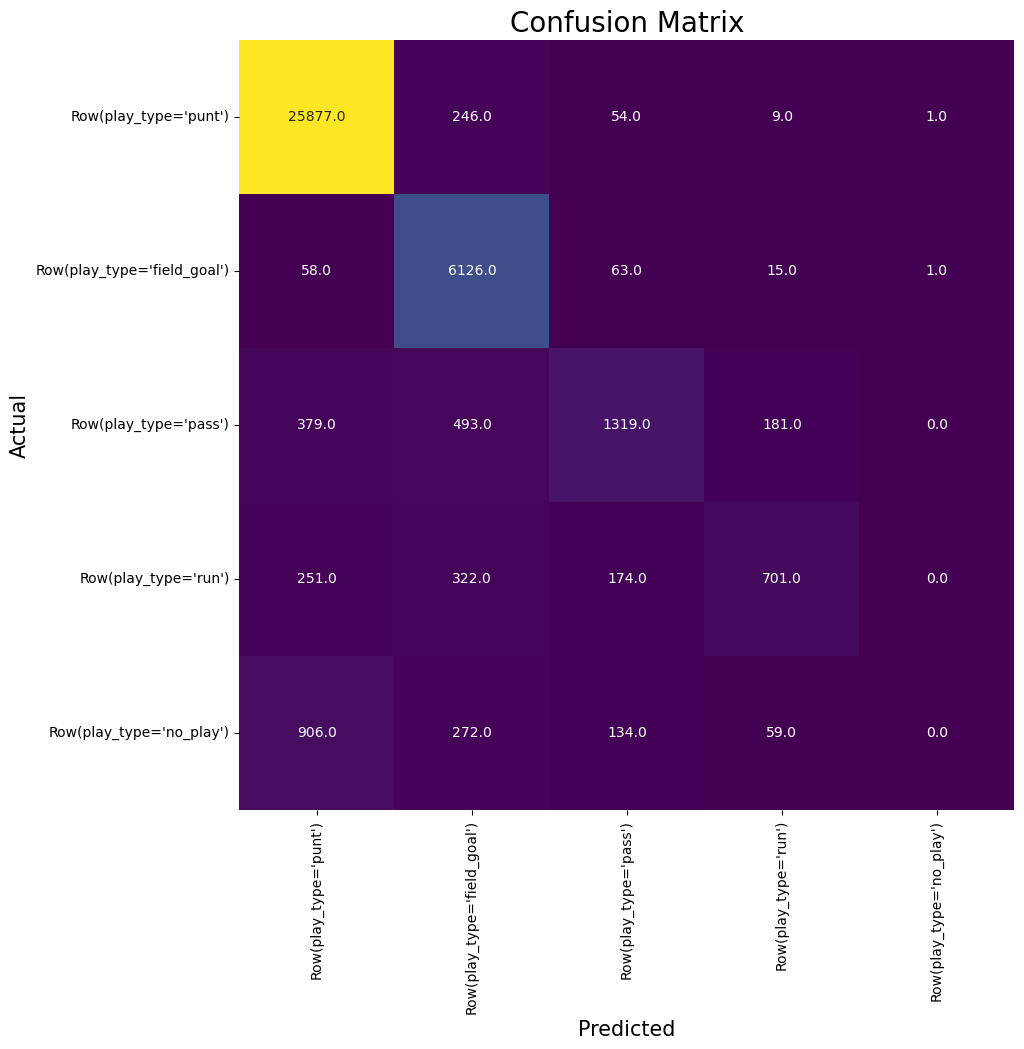

In [17]:
# labels = ["field_goal", "no_play", "pass", "punt", "run"]
_ = plt.figure(figsize=(10, 10))
ax = sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels,
            yticklabels=labels)

plt.title('Confusion Matrix', fontsize = 20) # title with fontsize 20
plt.xlabel('Predicted', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Actual', fontsize = 15) # y-axis label with fontsize 15

### Conclusions

Some quick observations:

* Much better performance when we don't undersample, could be because everything is a punt
* We need to be careful with the labels for the confusion matrix. They were not intially lining up properly with what the idxs are.
* I added temp, wind, roof, surface to the predictors